# Measuring monotonic relationships
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie with example algorithms by David Edwards

Reference: DeFusco, Richard A. "Tests Concerning Correlation: The Spearman Rank Correlation Coefficient." Quantitative Investment Analysis. Hoboken, NJ: Wiley, 2007


Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License. Please do not remove this attribution.

---

The Spearman Rank Correlation Coefficient allows us to determine whether or not two data series move together; that is, when one increases (decreases) the other also increases (decreases). This is more general than a linear relationship; for instance, $y = e^x$ is a monotonic function, but not a linear one. Therefore, in computing it we compare not the raw data but the ranks of the data.

This is useful when your data sets may be in different units, and therefore not linearly related (for example, the price of a square plot of land and its side length, since the price is more likely to be linear in the area). It's also suitable for data sets which not satisfy the assumptions that other tests require, such as the observations being normally distributed as would be necessary for a t-test.

In [50]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
from matplotlib import style
%matplotlib inline

In [2]:
# Example of ranking data
l = [10, 9, 5, 7, 5]
print('Raw Data: ', l)
print('Ranking: ', list(stats.rankdata(l, method='average')))

Raw Data:  [10, 9, 5, 7, 5]
Ranking:  [5.0, 4.0, 1.5, 3.0, 1.5]


## Spearman Rank Correlation

### Intuition

The intution is now that instead of looking at the relationship between the two variables, we look at the relationship between the ranks. This is robust to outliers and the scale of the data.

### Definition

The argument `method='average'` indicates that when we have a tie, we average the ranks that the numbers would occupy. For example, the two 5's above, which would take up ranks 1 and 2, each get assigned a rank of $1.5$.

To compute the Spearman rank correlation for two data sets $X$ and $Y$, each of size $n$, we use the formula
$$r_S = 1 - \frac{6 \sum_{i=1}^n d_i^2}{n(n^2 - 1)}$$

where $d_i$ is the difference between the ranks of the $i$th pair of observations, $X_i - Y_i$.

The result will always be between $-1$ and $1$. A positive value indicates a positive relationship between the variables, while a negative value indicates an inverse relationship. A value of 0 implies the absense of any monotonic relationship. This does not mean that there is no relationship; for instance, if $Y$ is equal to $X$ with a delay of 2, they are related simply and precisely, but their $r_S$ can be close to zero:

## Experiment

Let's see what happens if we draw $X$ from a poisson distribution (non-normal), and then set $Y = e^X + \epsilon$ where $\epsilon$ is drawn from another poisson distribution. We'll take the spearman rank and the correlation coefficient on this data and then run the entire experiment many times. Because $e^X$ produces many values that are far away from the rest, we can this of this as modeling 'outliers' in our data. Spearman rank compresses the outliers and does better at measuring correlation. Normal correlation is confused by the outliers and on average will measure less of a relationship than is actually there.

In [62]:
## Let's see an example of this
n = 100

def compare_correlation_and_spearman_rank(n, noise, noise_source='normal'):
    X = np.random.poisson(size=n)
    
    if noise_source == 'poisson':
        source = np.random.poisson(size=n)
    elif noise_source == 'laplace':
        source = np.random.laplace(size=n)
    elif noise_source == 'exp':
        source = np.random.exponential(size=n)
    elif noise_source == 'chi2':
        source = np.random.chisquare(df=2,size=n)
    elif noise_source == 'cauchy':
        source = np.random.standard_cauchy(size=n)
    else:
        source = np.random.normal(size=n)
        
    Y = np.exp(X) + (noise * source)
    
    Xrank = stats.rankdata(X, method='average')
    Yrank = stats.rankdata(Y, method='average')
    
    diffs = Xrank - Yrank # order doesn't matter since we'll be squaring these values
    r_s = 1 - (6*sum(diffs*diffs)) / (n*((n**2) - 1))
    c_c = np.corrcoef(X, Y)[0,1]
    
    return r_s, c_c

In [56]:

def correlation_experiment(n=1000, noise=1.0, noise_source='normal', plot_mode=False):
    spearman_dist = np.ndarray(n)
    correlation_dist = np.ndarray(n)

    for i in range(n):
        r_s, c_c = compare_correlation_and_spearman_rank(100, noise=noise, noise_source=noise_source)
        spearman_dist[i] = r_s
        correlation_dist[i] = c_c

    print('Noise Source: ', noise_source)
    print('Spearman Rank Coefficient: ', np.mean(spearman_dist))
    print('Correlation Coefficient: ', np.mean(correlation_dist))
    
    if plot_mode:
        plt.hist(spearman_dist, bins=50, alpha=0.5, label='Spearman Rank')
        plt.hist(correlation_dist, bins=50, alpha=0.5, label='Regular Correlation')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Frequency')
        plt.title('Ranking experiment with {0} noise'.format(noise_source))
    
experiments = 1000
noise_source = 'normal'

correlation_experiment(experiments, noise=1.0, noise_source=noise_source)

Noise Source:  normal
Spearman Rank Coefficient:  0.877868142814
Correlation Coefficient:  0.77296534172


In [46]:
experiments = 1000
noise_source = 'poisson'

correlation_experiment(experiments, 1.0, noise_source)

Noise Source:  poisson
Spearman Rank Coefficient:  0.872782940294
Correlation Coefficient:  0.773268613744


In [47]:
experiments = 1000
noise_source = 'laplace'

correlation_experiment(experiments, 1.0, noise_source)

Noise Source:  laplace
Spearman Rank Coefficient:  0.839427530753
Correlation Coefficient:  0.766247832185


In [48]:
experiments = 1000
noise_source = 'cauchy'

correlation_experiment(experiments, 1.0, noise_source)

Noise Source:  cauchy
Spearman Rank Coefficient:  0.687268772877
Correlation Coefficient:  0.423154976154


Let's take a look at the distribution of measured correlation coefficients and compare the spearman with the regular metric.

Noise Source:  normal
Spearman Rank Coefficient:  0.877134215422
Correlation Coefficient:  0.769548099452


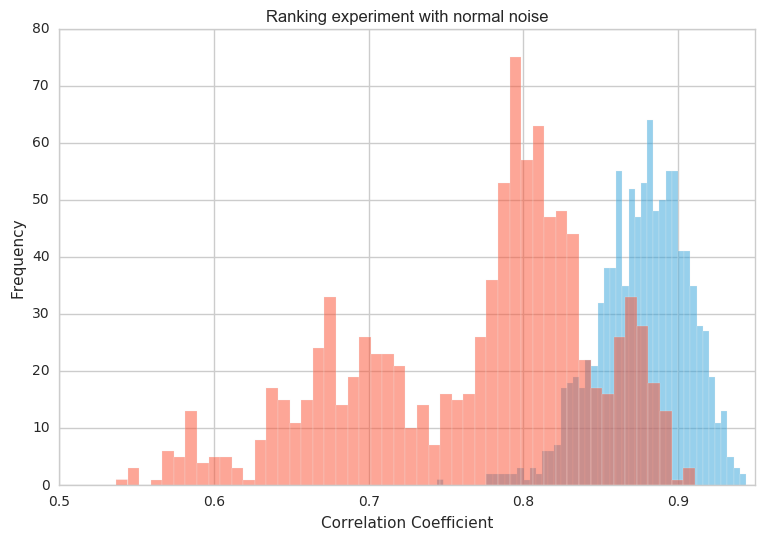

In [57]:
style.use('seaborn-whitegrid')

experiments = 1000
noise_source = 'normal'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Noise Source:  poisson
Spearman Rank Coefficient:  0.872756846685
Correlation Coefficient:  0.769741845305


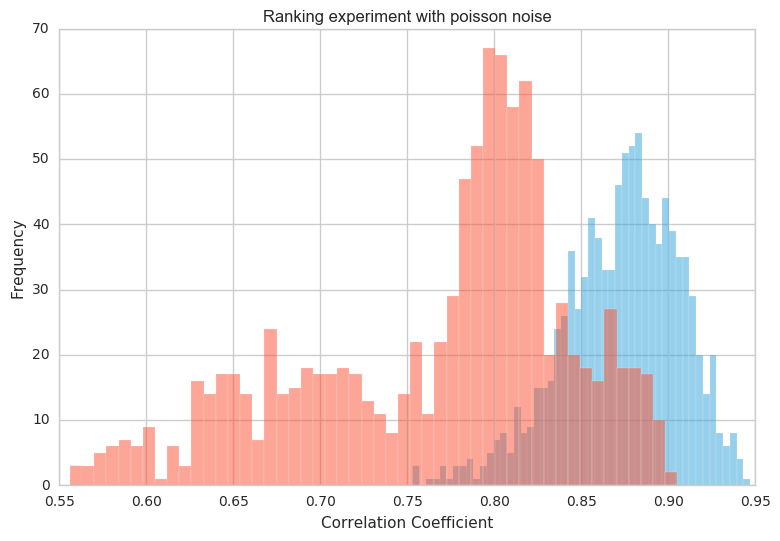

In [58]:
experiments = 1000
noise_source = 'poisson'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Noise Source:  laplace
Spearman Rank Coefficient:  0.838382871287
Correlation Coefficient:  0.768173542432


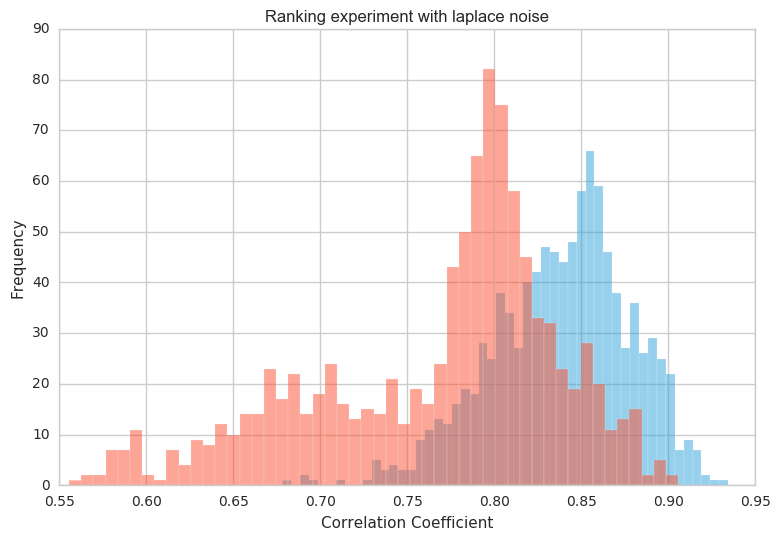

In [59]:
experiments = 1000
noise_source = 'laplace'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Noise Source:  exp
Spearman Rank Coefficient:  0.889055943594
Correlation Coefficient:  0.772009677685


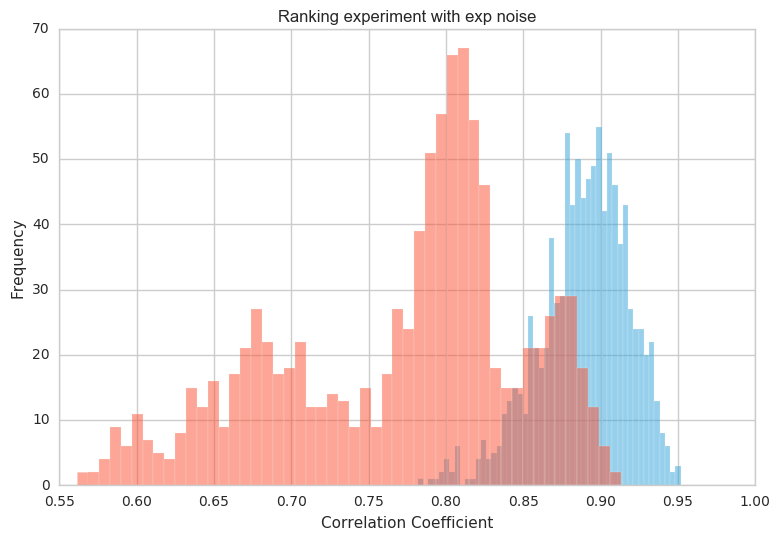

In [60]:
experiments = 1000
noise_source = 'exp'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Noise Source:  chi2
Spearman Rank Coefficient:  0.794185724572
Correlation Coefficient:  0.752352255475


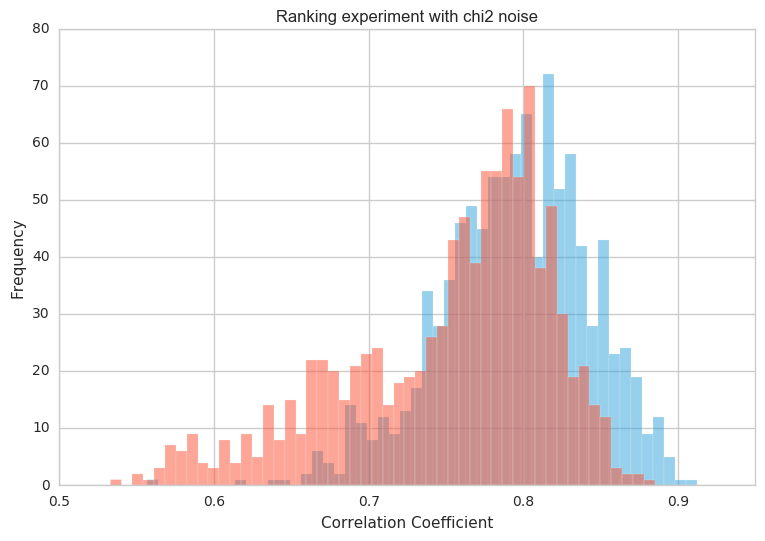

In [63]:
experiments = 1000
noise_source = 'chi2'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Noise Source:  cauchy
Spearman Rank Coefficient:  0.690790294029
Correlation Coefficient:  0.440002104572


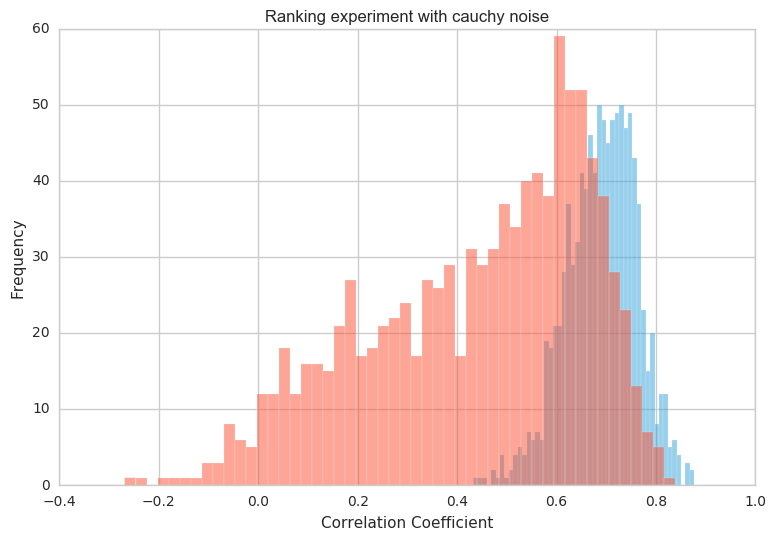

In [64]:
experiments = 1000
noise_source = 'cauchy'

correlation_experiment(experiments, 1.0, noise_source, plot_mode=True)

Now let's see how the Spearman rank and Regular coefficients cope when we add more noise to the situation.

In [77]:

def correlation_noise_test(n=100, experiments=100, noise_source='normal'):
    noises = np.linspace(0, 3, 30)
    spearman = np.ndarray(len(noises))
    correlation = np.ndarray(len(noises))

    for i in range(len(noises)):
        # Run many experiments for each noise setting
        rank_coef = 0.0
        corr_coef = 0.0
        noise = noises[i]
        for j in range(experiments):
            r_s, c_c = compare_correlation_and_spearman_rank(n, noise=noise, noise_source=noise_source)
            rank_coef += r_s
            corr_coef += c_c
        spearman[i] = rank_coef/experiments
        correlation[i] = corr_coef/experiments
        
    plt.scatter(noises, spearman, color='r', label='Spearman Rank')
    plt.scatter(noises, correlation, color='b',label='Regular Correlation')
    plt.xlabel('Amount of Noise')
    plt.ylabel('Average Correlation Coefficient')
    plt.legend()

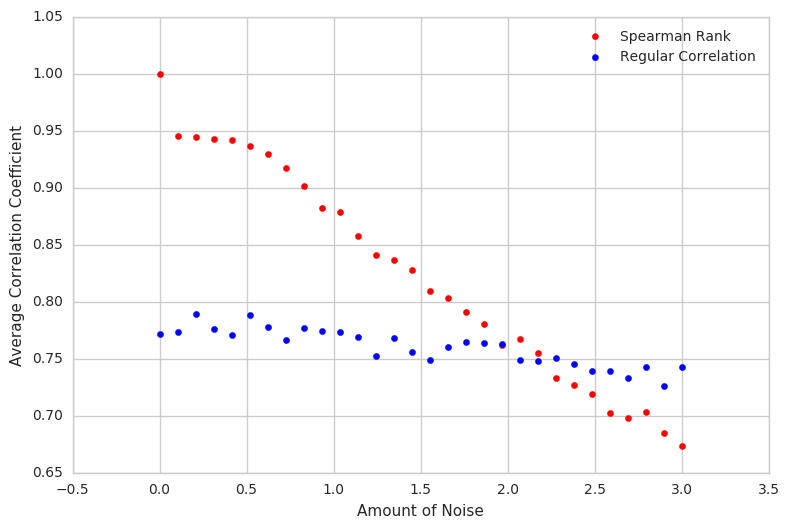

In [78]:
noise_source = 'normal'
correlation_noise_test(noise_source=noise_source);

We can see that the Spearman rank correlation copes with the non-linear relationship much better at most levels of noise. Interestingly, at very high levels, it seems to do worse than regular correlation.

## Delay in correlation

Of you might have the case that one process affects another, but after a time lag. Now let's see what happens if we add the delay.

In [79]:
def correlation_delay_test(n=100, delay=2):
    X = np.random.randn(n)
    Xrank = stats.rankdata(X, method='average')
    # n-2 is the second to last element
    Yrank = stats.rankdata([1]*delay + list(X[:(n-delay)]), method='average')

    diffs = Xrank - Yrank
    r_s = 1 - 6*sum(diffs*diffs) / (n*(n**2 - 1))
    return r_s

In [80]:
correlation_delay_test()

0.021923192319231899

Sure enough, the relationship is not detected. It is important when using both regular and spearman correlation to check for lagged relationships by offsetting your data and testing for different offset values.

## Built-In Function

We can also use the `spearmanr` function in the `scipy.stats` library:

In [81]:
# Generate two random data sets
np.random.seed(161)
X = np.random.rand(10)
Y = np.random.rand(10)

r_s = stats.spearmanr(X,Y)

print('Spearman Rank Coefficient: ',r_s[0])
print('p-value: ', r_s[1])

Spearman Rank Coefficient:  0.236363636364
p-value:  0.510885317515


We now have ourselves an $r_S$, but how do we interpret it? It's positive, so we know that the variables are not anticorrelated. It's not very large, so we know they aren't perfectly positively correlated, but it's hard to say from a glance just how significant the correlation is. Luckily, `spearmanr` also computes the p-value for this coefficient and sample size for us. We can see that the p-value here is above 0.05; therefore, we cannot claim that $X$ and $Y$ are correlated.

## Real World Example: Mutual Fund Expense Ratio

Now that we've seen how Spearman rank correlation works, we'll quickly go through the process again with some real data. For instance, we may wonder whether the expense ratio of a mutual fund is indicative of its three-year Sharpe ratio. That is, does spending more money on administration, management, etc. lower the risk or increase the returns? Quantopian does not currently support mutual funds, so we will pull the data from Yahoo Finance. Our p-value cutoff will be the usual default of 0.05.

### Data Source

Thanks to [Matthew Madurski](https://github.com/dursk) for the data. To obtain the same data:

1. Download the csv from this link. https://gist.github.com/dursk/82eee65b7d1056b469ab
2. Upload it to the 'data' folder in your research account.

In [82]:
import pandas as pd
import pandas_datareader.data as web

Spearman Rank coefficient:  -0.237573932355
p-values:  0.0167465097116


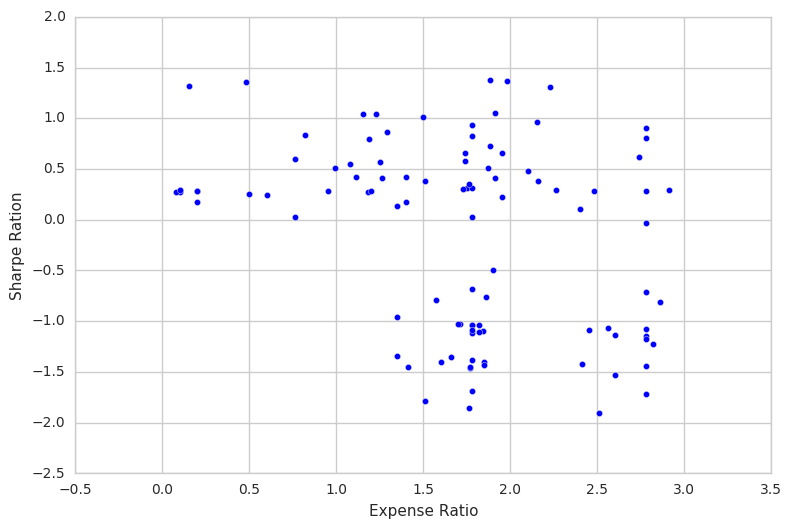

In [86]:
mutual_fund_data = pd.read_csv('mutual_fund_data.csv', )
expense = mutual_fund_data['Annual Expense Ratio'].values
sharpe = mutual_fund_data['Three Year Sharpe Ratio'].values

plt.scatter(expense, sharpe)
plt.xlabel('Expense Ratio')
plt.ylabel('Sharpe Ration')

r_s = stats.spearmanr(expense, sharpe)
print('Spearman Rank coefficient: ', r_s[0])
print('p-values: ',r_s[1])

Our p-value is below the cutoff, which means we accept the hypothesis that the two are correlated. The negative coefficient indicates that there is a negative correlation, and that more expensive mutual funds have worse sharpe ratios. However, there is some weird clustering in the data, it seems there are expensive groups with low sharpe ratios, and a main group whose sharpe ratio is unrelated to the expense. Further analysis would be required to understand what's going on here.

## Real World Use Case: Evaluating a Ranking Model

### NOTE: Lesson 18 now covers this topic in much greater detail
https://www.quantopian.com/lectures

Let's say that we have some way of ranking securities and that we'd like to test how well our ranking performs in practice. In this case our model just takes the mean daily return for the last month and ranks the stocks by that metric. 

We hypothesize that this will be predictive of the mean returns over the next month. To test this we score the stocks based on a lookback window, then take the spearman rank correlation of the score and the mean returns over the walk forward month.

Our scores: 

A       0.000100
AAC     0.008284
AAL     0.003004
AAMC   -0.004346
AAME    0.000092
AAN     0.000160
AAOI   -0.001057
AAON    0.000264
AAP     0.001491
AAPL    0.001415
AAT     0.001064
AAU    -0.001039
AAV     0.000411
AAWW    0.000781
AB      0.001060
ABAC   -0.000829
ABAX    0.001418
ABB    -0.000680
ABBV    0.001044
ABC     0.001068
ABCB    0.000842
ABCD   -0.000188
ABCO   -0.000878
ABCW    0.002654
ABDC   -0.000667
ABEV   -0.000438
ABG     0.001359
dtype: float64


The Walk Forward Returns
A      -0.003751
AAC    -0.008880
AAL    -0.004940
AAMC   -0.037649
AAME   -0.000525
AAN     0.001758
AAOI   -0.009899
AAON   -0.000289
AAP     0.000146
AAPL    0.003641
AAT     0.004984
AAU     0.012296
AAV    -0.005834
AAWW   -0.003622
AB     -0.004065
ABAC   -0.011672
ABAX    0.003331
ABB    -0.005081
ABBV   -0.004229
ABC     0.002605
ABCB   -0.002430
ABCD    0.018683
ABCO   -0.001766
ABCW   -0.002245
ABDC    0.001917
ABEV    0.005597
ABG    -0.001317
dtype: float64


Correlati

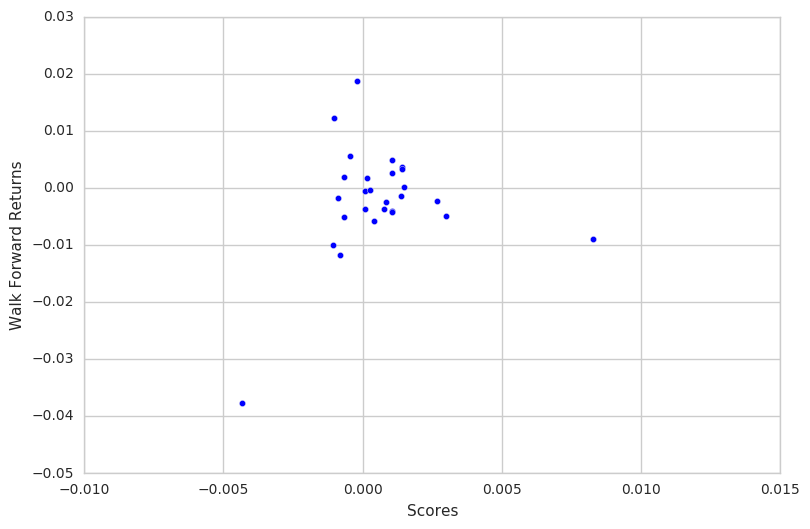

In [95]:
symbol_list = ['A', 'AAC', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 
               'AAPL', 'AAT', 'AAU', 'AAV', 'AAWW', 'AB', 'ABAC', 'ABAX', 'ABB',
               'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABCO', 'ABCW', 'ABDC', 'ABEV', 'ABG']

# get the returns over the lookback window
start = '2014-01-01'
end = '2015-01-01'
historecal_prices = web.DataReader(symbol_list, 'yahoo',start, end).loc['Adj Close',:,:]
historecal_returns = np.log(1 + historecal_prices.pct_change()).iloc[1:,:]

# Compute our stock score
scores = np.mean(historecal_returns)
print('Our scores: \n')
print(scores)
print('\n')

start = '2015-01-01'
end = '2015-02-01'
walk_forward_returns = np.log(1 + web.DataReader(symbol_list, 'yahoo',start, end).loc['Adj Close',:,:].pct_change()).iloc[1:,:]
walk_forward_returns = np.mean(walk_forward_returns)
print('The Walk Forward Returns')
print(walk_forward_returns)
print('\n')

plt.scatter(scores, walk_forward_returns)
plt.xlabel('Scores')
plt.ylabel('Walk Forward Returns')

r_s = stats.spearmanr(scores, walk_forward_returns)
print('Correlation Coefficient: ', r_s[0])
print('p-value: ', r_s[1])

The p-value indicates that our hypothesis is false and we accept the null hypothesis that our ranking was no better than random. This is a really good check of any ranking system one devises for constructing a long-short equity portfolio.